In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

c:\Users\Lales\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Lales\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\Lales\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.


Board of Governors of the Federal Reserve System (US), Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and Frozen Dessert (NAICS = 31152) [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, May 6, 2022.

In [2]:
df=pd.read_csv('resources/IPN.csv',parse_dates=True,index_col='DATE')
df.head(2)

,IPN31152N
DATE,
1972-01-01,60.1527
1972-02-01,67.2736


<AxesSubplot:xlabel='DATE'>

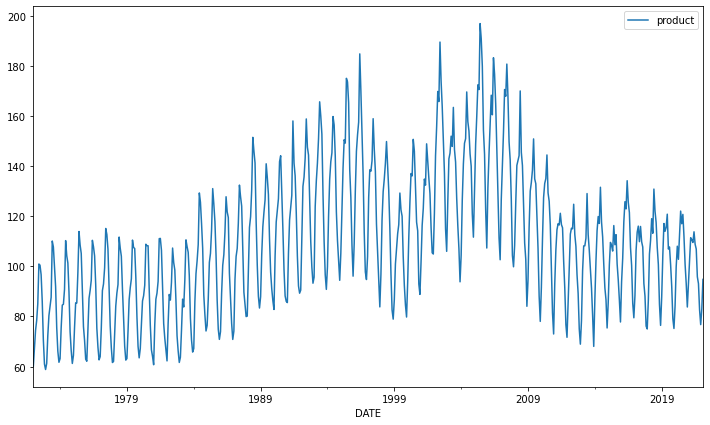

In [3]:
df.columns=['product']
df.plot(figsize=(12,7))

In [4]:
test_size=18
test_index=len(df)-test_size
train=df.iloc[:test_index]
test=df.iloc[test_index:]

In [5]:
sc=MinMaxScaler()
sc.fit(train)
scaled_tr=sc.transform(train)
scaled_test=sc.transform(test)

### Time Series Generator

In [6]:
length=12
n_features=1
generator=TimeseriesGenerator(scaled_tr,scaled_tr,length=length,batch_size=1)

In [7]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

### Creat model

In [8]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features),  return_sequences=True))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

### Model training

In [9]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)
history=model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
570/572 [============================>.] - ETA: 0s - loss: 0.0272WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C27001FF78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

<AxesSubplot:>

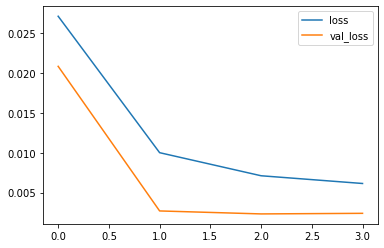

In [10]:
loss = pd.DataFrame(history.history)
loss.plot()

### Evaluate on test data

In [11]:
test_predictions = []

first_eval_batch = scaled_tr[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
true_predictions = sc.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test

,product,Predictions
DATE,,
2020-09-01,111.8634,101.704463
2020-10-01,100.7911,89.892325
2020-11-01,93.1239,82.089745
2020-12-01,83.7717,81.496891
2021-01-01,92.7025,85.998632
2021-02-01,101.2105,94.664832
2021-03-01,111.4117,98.763768
2021-04-01,110.6197,102.414010
2021-05-01,109.4956,112.197748


<AxesSubplot:xlabel='DATE'>

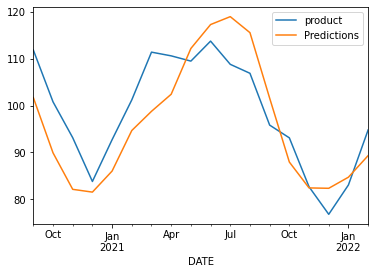

In [13]:
test.plot()

In [14]:

np.sqrt(mean_squared_error(test['product'],test['Predictions']))

7.404384599648589